In [69]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from torch.autograd import Variable
import numpy as np
from torchvision import transforms
import os
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import save_image

In [70]:
config = {
    "num_epochs":100,
    "lr":1e-3,
    "regular_constant":1e-5,
    "batch_size" : 128,
    "train_transform":transforms.Compose([
        transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]),
    "test_transform":transforms.Compose([
        transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]), 
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [71]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        self.encoder = nn.Sequential( 
            nn.Conv2d(in_channels = 1, out_channels = 28, kernel_size=5, stride=1, padding=0), #(28-5)+1 = 24
            nn.BatchNorm2d(28),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels = 28, out_channels = 32, kernel_size=5, stride=1, padding=0), #(12-5)+1 = 20
            # nn.Dropout(p=0.2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size=9, stride=1, padding=0), #(20-9)+1 = 12
            # nn.Dropout(p=0.2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,return_indices=True), # 20/2 = 10
            )
        self.upsample = nn.MaxUnpool2d(2)
        # input: [2, 32, 20, 20]
        # Deconve Formula:
        # H_out=(H_in −1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1
        # o = s*i+k-2p-s  o:output size, s:stride, i:input size, p:padding, k:kernel size
        # so here input is 20, 1*20+5-1 = 24
        self.decoder = nn.Sequential( 
            
            nn.ConvTranspose2d(in_channels = 16, out_channels = 32, kernel_size=9, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),


            nn.ConvTranspose2d(in_channels = 32, out_channels = 28, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(28),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(in_channels = 28, out_channels = 1, kernel_size=5, stride=1, padding=0),
            # nn.Dropout(p=0.2),
            nn.BatchNorm2d(1),
            nn.LeakyReLU(),
            )

    def forward(self,x):
        # print("the original is: ",x.shape)
        encoder, indices = self.encoder(x)
        # print(encoder.shape)
        output = self.upsample(encoder,indices)
        decoder = self.decoder(output)
        # print("after decorder ",decoder.shape)
        return decoder

In [72]:
from torchsummary import summary
summary(AutoEncoder().to(device), input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 28, 24, 24]             728
       BatchNorm2d-2           [-1, 28, 24, 24]              56
         LeakyReLU-3           [-1, 28, 24, 24]               0
            Conv2d-4           [-1, 32, 20, 20]          22,432
       BatchNorm2d-5           [-1, 32, 20, 20]              64
         LeakyReLU-6           [-1, 32, 20, 20]               0
            Conv2d-7           [-1, 16, 12, 12]          41,488
       BatchNorm2d-8           [-1, 16, 12, 12]              32
         LeakyReLU-9           [-1, 16, 12, 12]               0
        MaxPool2d-10  [[-1, 16, 6, 6], [-1, 16, 6, 6]]               0
      MaxUnpool2d-11           [-1, 16, 12, 12]               0
  ConvTranspose2d-12           [-1, 32, 20, 20]          41,504
      BatchNorm2d-13           [-1, 32, 20, 20]              64
        LeakyReLU-14           [

In [73]:
def to_img(x):
    x = (x + 1.) * 0.5
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

def compute_PSNR_score(mse):
    
    return 10 * np.log10(255 * 255 / mse)

In [74]:
def train(train_dataloader, validate_dataloader, device, config, path):
    model = AutoEncoder().to(device)
    optimizer = optim.Adam(
        model.parameters(),
        lr=config["lr"],
        betas=(0.9, 0.999),
        weight_decay=config["regular_constant"],
    )
    train_loss_value = []
    validate_loss_value = []
    train_accuracy = []
    validate_accuracy = []
    current_epoch = []
    best_psnr = 0.0
    # low_loss = torch.tensor(float('inf')).device()
    print("####### Training Processing #######")
    for epoch in range(config["num_epochs"]):
        model.train()
        train_loss = 0
        accuracy_score = 0
        total = 0
        current_epoch.append(epoch + 1)
        if epoch > 20:
            optimizer = optim.Adam(
                model.parameters(),
                lr=config["lr"] * 0.5,
                betas=(0.9, 0.999),
                weight_decay=config["regular_constant"],
            )
        if epoch > 30:
            optimizer = optim.Adam(
                model.parameters(),
                lr=config["lr"] * 0.2,
                betas=(0.9, 0.999),
                weight_decay=config["regular_constant"],
            )

        if epoch > 35:
            optimizer = optim.Adam(
                model.parameters(),
                lr=config["lr"] * 0.1,
                betas=(0.9, 0.999),
                weight_decay=config["regular_constant"],
            )

        for batch_idx, (inputs, targets) in enumerate(train_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, inputs)
            loss.backward()
            loss = loss.item()
            optimizer.step()
            train_loss += loss
            psnr = compute_PSNR_score(loss)
            total += targets.size(0)
            accuracy_score += psnr
        train_loss /= len(train_dataloader.dataset)
        accuracy_score /= len(train_dataloader.dataset)

        train_loss_value.append(train_loss)
        train_accuracy.append(accuracy_score)

        # Validation step
        model.eval()
        validation_loss = 0
        valid_psnr = 0
        with torch.no_grad():
            for data, target in validate_dataloader:
                data, target = data.to(device), target.to(device)
                output = model(data) 
                # pred = output.data.max(1, keepdim=True)[1]
                valid_loss = loss_function(output, data).item()
                psnr = compute_PSNR_score(valid_loss)
                # correct += pred.eq(target.data.view_as(pred)).sum().item()
                validation_loss += valid_loss
                valid_psnr += psnr 
            validation_loss /= len(validate_dataloader.dataset)
            valid_psnr /= len(validate_dataloader.dataset)


        if (epoch+1) % 5 == 0:
            print("\nIn epoch: ", epoch + 1)
            print("\nTraining set: Avg. loss: {:.6f}".format(train_loss))
            print("\nValidation set: Avg. loss: {:.6f}".format(validation_loss))

            pic = to_img(output.cpu().data)
            if not os.path.exists('./simple_autoencoder'):
                os.mkdir('./simple_autoencoder')
            save_image(pic, './simple_autoencoder/image_{}.png'.format(epoch + 1))

        validate_loss_value.append(validation_loss)
        validate_accuracy.append(valid_psnr)
        if valid_psnr > best_psnr:
            best_psnr = valid_psnr

            torch.save(model.state_dict(), os.path.join(path, "ckpt.pth"))
            print("model save at checkpoint")

    plt.plot(current_epoch, train_loss_value, "b", label="Training Loss")
    plt.plot(current_epoch, validate_loss_value, "r", label="Validation Loss")
    plt.title("Loss v.s. Epochs")
    plt.legend()
    plt.savefig(os.path.join(path, "loss_curve.jpg"))
    plt.figure()

    plt.plot(current_epoch, train_accuracy, "b", label="Training Accuracy")
    plt.plot(current_epoch, validate_accuracy, "r", label="Validation Accuracy")
    plt.title("Accuracy v.s. Epochs")
    plt.legend()
    plt.savefig(os.path.join(path, "accuracy.jpg"))
    plt.show()
    return model

In [75]:
def test(test_dataloader, model, device):
    test_predictions = []
    true_labels = []
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_dataloader:
            data,target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_function(output, data)
            test_loss += loss.item()
            # pred = output.data.max(1, keepdim=True)[1]
            # test_predictions.append(pred[0])
            # true_labels.append(target.data.view_as(pred)[0])
            # correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_dataloader.dataset)
        # print(
        #     "Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
        #         test_loss,
        #         correct,
        #         len(test_dataloader.dataset),
        #         100.0 * correct.item() / len(test_dataloader.dataset),
        #     )
        # )
        pic = to_img(output.cpu().data)
        if not os.path.exists('./simple_autoencoder'):
            os.mkdir('./simple_autoencoder')
        save_image(pic, './simple_autoencoder/{}_image.png'.format("Test"))
        print("\nTest set: Avg. loss: {:.6f}".format(test_loss))

In [76]:
train_data = torchvision.datasets.MNIST(
    root='./data/', 
    train=True,
    transform = config["train_transform"],  
    download=False,  
)

test_data = torchvision.datasets.MNIST(
    root='./data/', 
    train=False, 
    transform = config["test_transform"],  
    download=False,  
)
training_set, validation_set = torch.utils.data.random_split(train_data, [int(len(train_data)*0.8), int(len(train_data)*0.2)])

train_loader = Data.DataLoader(
    training_set,
    batch_size = config["batch_size"],
    shuffle = True,
    ) 

vali_loader = Data.DataLoader(
    validation_set,
    batch_size = config["batch_size"],
    shuffle = True,
    ) 

test_loader  = Data.DataLoader(
    test_data,
    batch_size = config["batch_size"],
    shuffle = False,
)

####### Training Processing #######
model save at checkpoint
model save at checkpoint
model save at checkpoint
model save at checkpoint

In epoch:  5

Training set: Avg. loss: 0.001184

Validation set: Avg. loss: 0.001184
model save at checkpoint
model save at checkpoint
model save at checkpoint
model save at checkpoint

In epoch:  10

Training set: Avg. loss: 0.001132

Validation set: Avg. loss: 0.001127
model save at checkpoint
model save at checkpoint
model save at checkpoint
model save at checkpoint
model save at checkpoint

In epoch:  15

Training set: Avg. loss: 0.001094

Validation set: Avg. loss: 0.001091
model save at checkpoint
model save at checkpoint
model save at checkpoint
model save at checkpoint
model save at checkpoint

In epoch:  20

Training set: Avg. loss: 0.001063

Validation set: Avg. loss: 0.001056
model save at checkpoint
model save at checkpoint
model save at checkpoint
model save at checkpoint

In epoch:  25

Training set: Avg. loss: 0.001038

Validation set: 

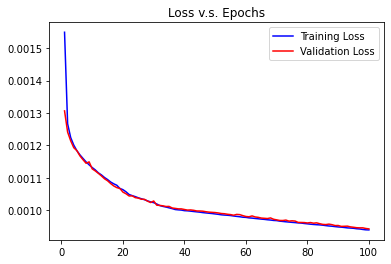

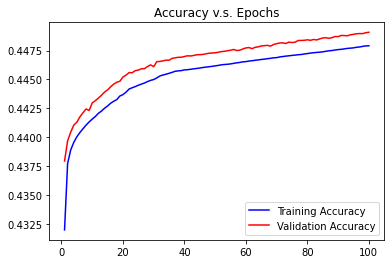


Test set: Avg. loss: 0.000948


([], [])

In [77]:
loss_function = nn.MSELoss()
# if os.path.exists("ckpt.pth"):
#     checkpoint = torch.load("ckpt.pth", map_location=device)
#     model = AutoEncoder().to(device)
#     model.load_state_dict(checkpoint)
# else:
#     model = train(train_loader, vali_loader, device, config, os.getcwd())
model = train(train_loader,vali_loader,device,config,path = os.getcwd())
test(test_loader,model,device)